In [24]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt, cm as cm, mlab as mlab
from sklearn.preprocessing import StandardScaler
import seaborn as sns; sns.set()
from sklearn.mixture import GaussianMixture as GMM
import math

In [9]:
# read csv/excel data files 
pnas_data1 = pd.read_csv('/home/jaeweon/research/data/pnas_data1.csv')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [11]:
def svd(data):
    """
    perform singular value decomposition on the given data matrix
    """
    #center the data
    mean = np.mean(data, axis=0)
    data -= mean
    
    P, D, Q = np.linalg.svd(data, full_matrices=False)
    
    return P, D, Q

In [12]:
# format data 

# extract 9 Complexity Characteristic variables 
features = ['PolPop', 'PolTerr', 'CapPop', 'levels', 'government','infrastr', 'writing', 'texts', 'money']

# take subset of original data table with 9 CCs and change it into numpy array 
data_mat = pnas_data1.loc[:, features].values
scaled = StandardScaler().fit_transform(data_mat)
P, D, Q = svd(scaled)
data = np.matmul(scaled, Q.T) # data matrix is obtained by multiplying initial data matrix with SVD column matrix

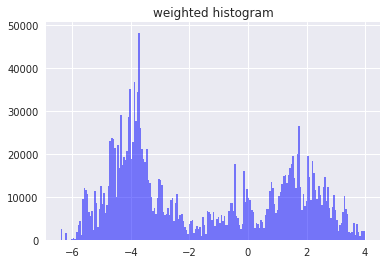

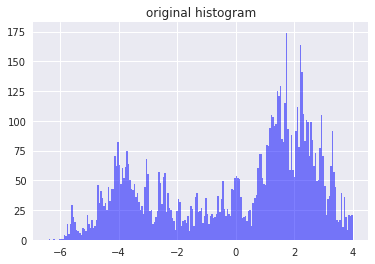

In [50]:
# compute the average temporal gap size for each data point (with respect to regions)
temporal_gap = dict()
weighted = list()
unique_region = pnas_data1.NGA.unique().tolist()
period = list()

for impute_step in range(1, 21):
    for nga in unique_region:
        times = sorted(pnas_data1[pnas_data1.NGA == nga].Time.unique().tolist())
        for time in range(len(times)):
            idx = pnas_data1.index[(pnas_data1.irep == impute_step) & (pnas_data1.NGA == nga) & 
                                    (pnas_data1.Time == times[time])].tolist()[0]
            if time == 0: # the data point is the first appearance of a polity in the nga
                temporal_gap[idx] = int(round((times[time+1]-times[time])))
            elif time == len(times)-1: # the data point is the last time period of the recorded nga
                temporal_gap[idx] = int(round((times[time] - times[time-1])))
            else: 
                temporal_gap[idx] = int(round((-times[time-1]+times[time+1])/2))

assert len(temporal_gap.keys()) == 8280 # temporal_gap must contain all 8280 points

# wegiht the occurence of each data point by their respective temporal gap size
for i in range(len(data[:,0])):
    weighted.extend(temporal_gap[i]*[data[:,0][i]])
    
num_bins = 200
n, bins, patches = plt.hist(weighted, num_bins, normed=False, facecolor='blue', alpha=0.5)

plt.title('weighted histogram')
plt.show()
plt.close()

n, bins, patches = plt.hist(data[:,0], num_bins, normed=False, facecolor='blue', alpha=0.5)

plt.title('original histogram')
plt.show()
plt.close()


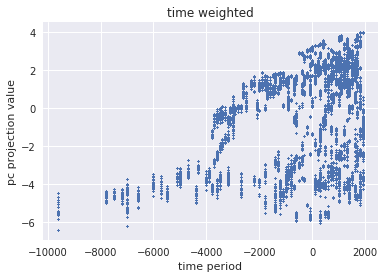

In [59]:
# 2d scatter plots for original data, interpolated data, and time weighted data with 
# positions along PC and date as two axes 

# compute the average temporal gap size for each data point (with respect to regions)
temporal_gap = dict()
weighted = list()
period = list()
unique_region = pnas_data1.NGA.unique().tolist()

for impute_step in range(1, 21):
    for nga in unique_region:
        times = sorted(pnas_data1[pnas_data1.NGA == nga].Time.unique().tolist())
        for time in range(len(times)):
            idx = pnas_data1.index[(pnas_data1.irep == impute_step) & (pnas_data1.NGA == nga) & 
                                    (pnas_data1.Time == times[time])].tolist()[0]
            if time == 0: # the data point is the first appearance of a polity in the nga
                temporal_gap[idx] = int(round((times[time+1]-times[time])))
            elif time == len(times)-1: # the data point is the last time period of the recorded nga
                temporal_gap[idx] = int(round((times[time] - times[time-1])))
            else: 
                temporal_gap[idx] = int(round((-times[time-1]+times[time+1])/2))

assert len(temporal_gap.keys()) == 8280 # temporal_gap must contain all 8280 points

# wegiht the occurence of each data point by their respective temporal gap size
for i in range(len(data[:,0])):
    weighted.extend(temporal_gap[i]*[data[:,0][i]])
    period.extend(temporal_gap[i]*[int(pnas_data1.loc[i]['Time'])])

assert len(weighted) == len(period)

plt.scatter(period, weighted, s=1)
plt.title('time weighted')
plt.xlabel('time period')
plt.ylabel('pc projection value')
plt.show()
plt.close()